In [1]:
import numpy as np
import os
import pandas as pd
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow_hub as hub
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# enable gpu growth if gpu is available
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
for device in gpu_devices:
    tf.config.experimental.set_memory_growth(device, True)

# tf.keras.mixed_precision.set_global_policy('mixed_float16')

tf.config.optimizer.set_jit(True)

%load_ext watermark
%watermark -v -iv

tensorflow       2.4.0
json             2.0.9
tensorflow.keras 2.4.0
tensorflow_hub   0.9.0
pandas           1.0.5
autopep8         1.5.4
numpy            1.19.5
CPython 3.7.4
IPython 7.8.0


# The Data is taken from https://www.kaggle.com/mkechinov/ecommerce-behavior-data-from-multi-category-store and https://rees46.com/
## Each record/line in the file has the following fields:
1. event_time: When did the event happened (UTC)
2. event_type: Event type: one of [view, cart, remove_from_cart, purchase] 
3. product_id
4. category_id
5. category_code: Category meaningful name (if present)
6. brand: Brand name in lower case (if present)
7. price
8. user_id: Permanent user ID
9. user_session: User session ID

In [2]:
# Read first 500.000 Rows
for chunk in pd.read_table("2019-Dec.csv",
                           sep=",", header=0,
                           infer_datetime_format=True, low_memory=False, chunksize=500000):
    # Filter out other event types than 'view'
    chunk = chunk[chunk['event_type'] == 'view']
    # Filter out missing 'category_code' rows
    chunk = chunk[chunk['category_code'].isna() == False]
    chunk.reset_index(drop=True, inplace=True)

    # Filter out all Sessions of length 1
    count_sessions = chunk.groupby('user_session').count()
    window_length = count_sessions.max()[0]
    unique_sessions = [count_sessions.index[i] for i in range(
        count_sessions.shape[0]) if count_sessions.iloc[i, 0] == 1]
    chunk = chunk[~chunk['user_session'].isin(unique_sessions)]
    chunk.reset_index(drop=True, inplace=True)

    # Text embedding based on https://tfhub.dev/google/nnlm-en-dim50/2
    last_category = []
    for i, el in enumerate(chunk['category_code']):
        last_category.append(el.split('.')[-1])
    chunk['Product'] = last_category
    embed = hub.load("https://tfhub.dev/google/nnlm-en-dim50/2")
    embeddings = embed(chunk['Product'].tolist())
    for dim in range(embeddings.shape[1]):
        chunk['embedding_'+str(dim)] = embeddings[:, dim]

    # Standardization
    mean = chunk['price'].mean(axis=0)
    print('Mean:', mean)
    std = chunk['price'].std(axis=0)
    print('Std:', std)
    chunk['price_standardized'] = (chunk['price'] - mean) / std

    chunk.sort_values(by=['user_session', 'event_time'], inplace=True)
    chunk['price_standardized'] = chunk['price_standardized'].astype('float32')
    chunk['product_id'] = chunk['product_id'].astype('int32')
    chunk.reset_index(drop=True, inplace=True)

    print('Sessions:', pd.unique(chunk['user_session']).shape)
    print('Unique Products:', pd.unique(chunk['product_id']).shape)
    print('Unique category_code:', pd.unique(chunk['category_code']).shape)

    columns = ['embedding_'+str(i) for i in range(embeddings.shape[1])]
    columns.append('price_standardized')
    columns.append('user_session')
    columns.append('Product')
    columns.append('product_id')
    columns.append('category_code')

    df = chunk[columns]
    break

mapping = pd.read_csv('../ID_Mapping.csv')[['Item_ID', 'Mapped_ID']]
dict_items = mapping.set_index('Item_ID').to_dict()['Mapped_ID']

df['product_id_mapped'] = df['product_id'].map(dict_items)   
df

Mean: 284.77105468660056
Std: 349.4674023158121
Sessions: (61296,)
Unique Products: (38515,)
Unique category_code: (134,)


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,embedding_0,embedding_1,embedding_2,embedding_3,embedding_4,embedding_5,embedding_6,embedding_7,embedding_8,embedding_9,...,embedding_46,embedding_47,embedding_48,embedding_49,price_standardized,user_session,Product,product_id,category_code,product_id_mapped
0,0.047610,-0.125734,-0.053261,0.196848,-0.016433,0.049773,0.012852,0.263229,-0.195415,0.327227,...,0.090539,0.104421,0.061444,-0.008996,-0.373028,0000afb3-2d30-4b52-84ec-07c6617efd37,light,1004838,construction.tools.light,311.0
1,0.047610,-0.125734,-0.053261,0.196848,-0.016433,0.049773,0.012852,0.263229,-0.195415,0.327227,...,0.090539,0.104421,0.061444,-0.008996,-0.373028,0000afb3-2d30-4b52-84ec-07c6617efd37,light,1004838,construction.tools.light,311.0
2,0.047610,-0.125734,-0.053261,0.196848,-0.016433,0.049773,0.012852,0.263229,-0.195415,0.327227,...,0.090539,0.104421,0.061444,-0.008996,0.068930,0000b83c-9b26-4881-8bca-e20d460f4194,light,1005252,construction.tools.light,1.0
3,0.047610,-0.125734,-0.053261,0.196848,-0.016433,0.049773,0.012852,0.263229,-0.195415,0.327227,...,0.090539,0.104421,0.061444,-0.008996,0.289895,0000b83c-9b26-4881-8bca-e20d460f4194,light,1004503,construction.tools.light,1259.0
4,0.047610,-0.125734,-0.053261,0.196848,-0.016433,0.049773,0.012852,0.263229,-0.195415,0.327227,...,0.090539,0.104421,0.061444,-0.008996,-0.291904,0000f7c4-8836-4507-82a1-8a10de3fb1b2,light,1005191,construction.tools.light,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
369299,0.174397,-0.204014,-0.175919,0.105906,-0.205940,-0.210022,0.224095,0.210598,-0.162613,0.150693,...,-0.129293,-0.176801,0.100340,0.119850,-0.630791,fffdfd5e-126c-409f-9c16-8224f22cb60b,cooler,4400467,computers.components.cooler,4002.0
369300,0.047610,-0.125734,-0.053261,0.196848,-0.016433,0.049773,0.012852,0.263229,-0.195415,0.327227,...,0.090539,0.104421,0.061444,-0.008996,-0.511696,fffe34dd-9537-4991-9f12-d81f1dda91cb,light,1004903,construction.tools.light,137.0
369301,0.047610,-0.125734,-0.053261,0.196848,-0.016433,0.049773,0.012852,0.263229,-0.195415,0.327227,...,0.090539,0.104421,0.061444,-0.008996,-0.511696,fffe34dd-9537-4991-9f12-d81f1dda91cb,light,1004903,construction.tools.light,137.0
369302,0.047610,-0.125734,-0.053261,0.196848,-0.016433,0.049773,0.012852,0.263229,-0.195415,0.327227,...,0.090539,0.104421,0.061444,-0.008996,-0.459760,fffe34dd-9537-4991-9f12-d81f1dda91cb,light,1004856,construction.tools.light,66.0


In [3]:
sessions_padded = np.load('list_sessions_padded_autoencoder.npy')
print(sessions_padded.shape)
n_output_features = int(sessions_padded.max())
n_unique_input_ids = int(sessions_padded.max())
window_length = sessions_padded.shape[1]
n_input_features = sessions_padded.shape[2]

(30941, 31, 1)


### LSTM Autoencoder in functional API
- Input: x rows (time steps) of Item IDs in a Session
- Output: reconstructed Session

In [4]:
def build_autoencoder(window_length=50,
                      units_lstm_layer=100,
                      n_unique_input_ids=0,
                      embedding_dim=200,
                      n_input_features=1,
                      n_output_features=3,
                      dropout_rate=0.1):

    inputs = keras.layers.Input(
        shape=[window_length, n_input_features], dtype=np.float32)

    # Encoder
    # Embedding Layer
    embedding_layer = tf.keras.layers.Embedding(
        n_unique_input_ids+1, embedding_dim, input_length=window_length)  # , mask_zero=True)
    embeddings = embedding_layer(inputs[:, :, 0])

    mask = inputs[:, :, 0] != 0

    # LSTM Layer 1
    lstm1_output, lstm1_state_h, lstm1_state_c = keras.layers.LSTM(units=units_lstm_layer, return_state=True,
                                                                   return_sequences=True)(embeddings, mask=mask)
    lstm1_state = [lstm1_state_h, lstm1_state_c]

    # Decoder
    # input: lstm1_state_c, lstm1_state_h
    decoder_state_c = lstm1_state_c
    decoder_state_h = lstm1_state_h
    decoder_outputs = tf.expand_dims(lstm1_state_h, 1)

    list_states = []
    decoder_layer = keras.layers.LSTM(
        units=units_lstm_layer, return_state=True, return_sequences=True, unroll=False)
    for i in range(window_length):
        decoder_outputs, decoder_state_h, decoder_state_c = decoder_layer(decoder_outputs,
                                                                          initial_state=[decoder_state_h,
                                                                                         decoder_state_c])
        list_states.append(decoder_state_h)
    stacked = tf.stack(list_states, axis=1)

    fc_layer = tf.keras.layers.Dense(
        n_output_features+1, kernel_initializer='he_normal')

    fc_layer_output = tf.keras.layers.TimeDistributed(fc_layer)(
        stacked, mask=mask)

    mask_softmax = tf.tile(tf.expand_dims(mask, axis=2),
                           [1, 1, n_output_features+1])

    softmax = tf.keras.layers.Softmax(axis=2, dtype=tf.float32)(
        fc_layer_output, mask=mask_softmax)

    model = keras.models.Model(inputs=[inputs],
                               outputs=[softmax])
    return model

In [5]:
model = build_autoencoder(window_length=window_length,
                                             n_output_features=n_output_features,
                                             n_unique_input_ids=n_unique_input_ids,
                                             n_input_features=n_input_features,
                                             embedding_dim=200,
                                             units_lstm_layer=300,
                                             dropout_rate=0.0)
model.load_weights("weights")

In [6]:
id_mapping = pd.read_csv('../ID_Mapping.csv')
distribution_items = df.groupby('product_id_mapped').count()

if os.path.isfile('errors.npy'):
    errors = np.load('errors.npy')
else:
    list_errors = []
    bce = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=False, reduction='sum')
    batch_size = 128 # lower batch size, if your gpu memory isnt high enough

    try:
        for i in range(0, sessions_padded.shape[0], batch_size):
            y_pred = model(sessions_padded[i:i+batch_size])
            y_true = sessions_padded[i:i+batch_size]

            for batch in range(0, batch_size, 1):
                total = 0.0
                for j in range(sessions_padded.shape[1]):
                    if y_true[batch, j, 0] > 0:
                        loss = bce(y_true[batch, j, 0], y_pred[batch, j, :])
                        total = total + loss
                    else:
                        break
                list_errors.append(total.numpy())
    except Exception as e:
        print(e)
    errors = np.array(list_errors)
    np.save('errors.npy', errors)

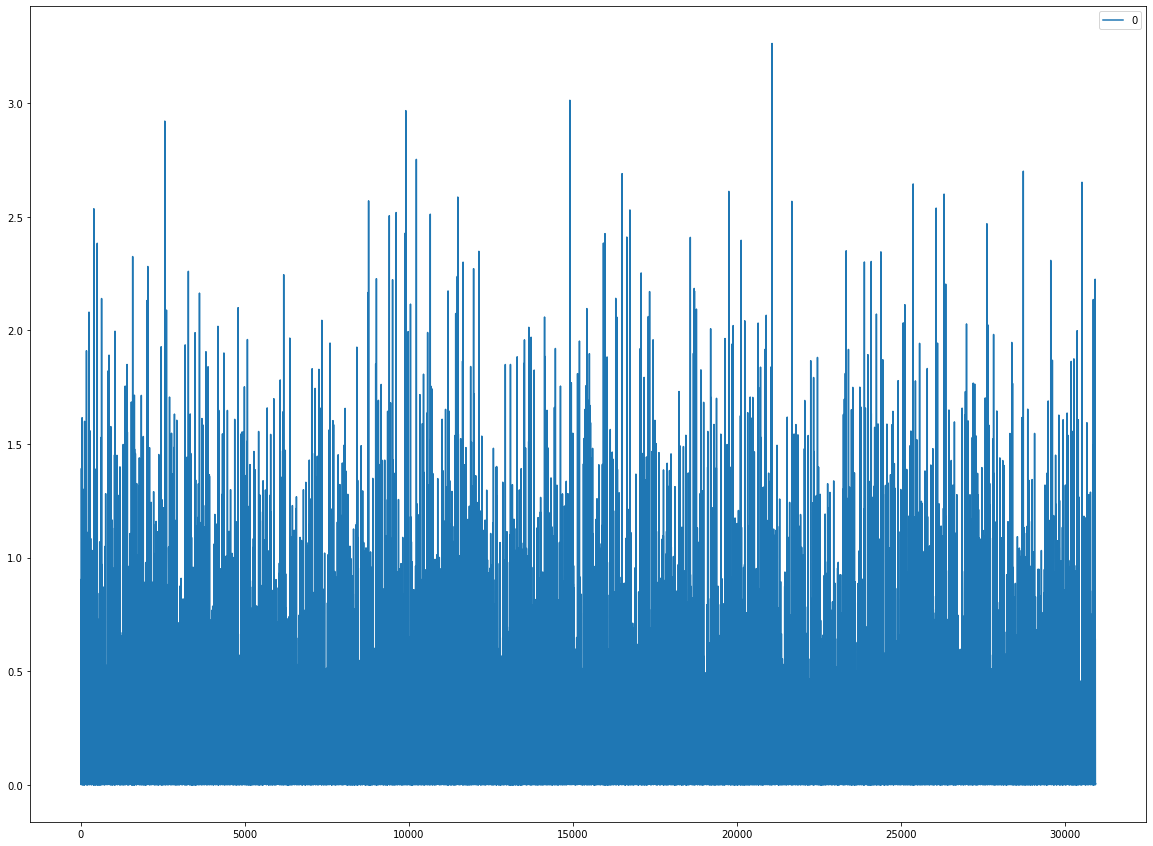

In [13]:
mask = sessions_padded[:, :, 0]!=0
lengths_session = mask.sum(axis=1)
mean_errors = errors/lengths_session
pd.DataFrame(mean_errors).plot(figsize=(20,15))

In [8]:
tmp = np.where(mean_errors>1.9)
tmp

(array([  169,   246,   394,   498,   630,  1039,  1578,  2008,  2040,
         2447,  2557,  2609,  3179,  3276,  3481,  3615,  3813,  4179,
         4361,  4794,  5077,  6184,  6369,  7347,  7596,  8415,  8761,
         8773,  9011,  9404,  9504,  9613,  9880,  9907,  9978, 10050,
        10229, 10573, 10654, 11196, 11429, 11477, 11493, 11654, 11975,
        12135, 13526, 13659, 13729, 14139, 14469, 14910, 15203, 15429,
        15934, 15982, 16310, 16352, 16504, 16647, 16743, 17046, 17085,
        17302, 17342, 17449, 18584, 18702, 18711, 18770, 19204, 19642,
        19758, 19863, 19891, 20135, 20244, 20652, 20865, 20899, 21077,
        21680, 23338, 23407, 23892, 24101, 24257, 24259, 24396, 25078,
        25127, 25380, 25576, 26071, 26082, 26123, 26323, 26373, 27007,
        27629, 27664, 27833, 28388, 28739, 29576, 29588, 30381, 30529,
        30873, 30930], dtype=int64),)

In [9]:
example = 169 # 23279
session = pd.DataFrame()
session['category_code'] = [id_mapping['category_code'][int(i)-1] for i in sessions_padded[example,:,0] if i>0]
session['Item_ID'] = [id_mapping['Item_ID'][int(i)-1] for i in sessions_padded[example,:,0] if i>0]
session['Item_ID_Mapped'] = [int(i) for i in sessions_padded[example,:,0] if i>0]
session['Count'] = [distribution_items.loc[i, 'embedding_0'] for i in session['Item_ID_Mapped']]
#session.drop(['Item_ID_Mapped'], axis=1, inplace=True)
session
mean_errors[example], errors[example]

,category_code,Item_ID,Item_ID_Mapped,Count
0,electronics.audio.acoustic,14100052.0,349,27
1,electronics.audio.acoustic,14100285.0,350,16
2,electronics.audio.acoustic,14100052.0,349,27
3,apparel.shoes,4100126.0,351,188
4,computers.components.power_supply,11500273.0,352,84
5,apparel.shoes,9300000.0,291,82
6,construction.tools.light,1004249.0,246,1145
7,construction.tools.light,1005105.0,152,1607
8,construction.tools.light,1005159.0,353,981
9,construction.tools.light,1005235.0,354,413


(1.910614013671875, 34.391052)

# Custom Session

In [10]:
y_true = np.zeros((1, 31, 1), dtype=np.int32)
y_true[0,0,0] = 2499
y_true[0,1,0] = 29
y_true[0,2,0] = 100
y_true[0,3,0] = 1001 #1000
y_true[0,4,0] = 1507
y_true[0,5,0] = 501 #3000

In [11]:
list_errors = []
bce = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False, reduction='sum')
batch_size = 1

for i in range(0, y_true.shape[0], batch_size):
    y_pred = model(y_true)
    
    for batch in range(0, batch_size, 1):
        total = 0.0
        for j in range(sessions_padded.shape[1]):
            if y_true[batch,j,0] > 0:
                loss = bce(y_true[batch,j,0], y_pred[batch,j,:])
                total = total + loss
            else:
                break
        list_errors.append(total.numpy())

errors_2 = np.array(list_errors)
mask = y_true[:, :, 0]!=0
lengths_session = mask.sum(axis=1)
mean_errors_2 = errors_2/lengths_session
mean_errors_2

array([8.75680351])

In [12]:
session = pd.DataFrame()
session['category_code'] = [id_mapping['category_code'][int(i)-1] for i in y_true[0,:,0] if i>0]
session['Item_ID'] = [id_mapping['Item_ID'][int(i)-1] for i in y_true[0,:,0] if i>0]
session['Item_ID_Mapped'] = [int(i) for i in y_true[0,:,0] if i>0]
session['Count'] = [distribution_items.loc[i, 'embedding_0'] for i in session['Item_ID_Mapped']]
#session.drop(['Item_ID_Mapped'], axis=1, inplace=True)
session

,category_code,Item_ID,Item_ID_Mapped,Count
0,appliances.kitchen.blender,3100204.0,2499,9
1,appliances.personal.massager,1801226.0,29,175
2,computers.ebooks,5100605.0,100,15
3,furniture.kitchen.chair,10100202.0,1001,18
4,furniture.kitchen.chair,11400736.0,1507,15
5,apparel.shoes.keds,2300307.0,501,19
